In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# # 데이터 받기 및 불러오기
  * https://www.kaggle.com/c/bike-sharing-demand/data

In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

bike_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/머신러닝/권철민-파이썬머신러닝완벽가이드(위키북스)/res/bike-sharing-demand/train.csv')
print(bike_df.shape)
bike_df.head(3)

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32


In [27]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


# # datetime 컬럼을 년,월,일,시간으로 따로 추출

In [28]:
# 문자열을 datetime 타입으로 변경. 
bike_df['datetime'] = bike_df.datetime.apply(pd.to_datetime)

# datetime 타입에서 년, 월, 일, 시간 추출
bike_df['year'] = bike_df.datetime.apply(lambda x : x.year)
bike_df['month'] = bike_df.datetime.apply(lambda x : x.month)
bike_df['day'] = bike_df.datetime.apply(lambda x : x.day)
bike_df['hour'] = bike_df.datetime.apply(lambda x: x.hour)
bike_df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2


# # 불필요한 컬럼 제거
  * datetime 컬럼 삭제
  * casual 
    - 사전에 등록하지 않은 사용자의 자전거 대여 횟수
  * registered
    - 사전에 등록한 사용자의 대여 횟수
  * count만 있어도 된다.
    - casual + registered 이기 때문 
    - causal, registered는 count와 상관도가 높아서 예측에 방해가 될 수 있으므로 삭제를 하면 더더욱 좋다.

In [29]:
drop_columns = ['datetime','casual','registered']
bike_df.drop(drop_columns, axis=1,inplace=True)

# # 컬럼별 count 시각화

## ## enumerate 함수

In [30]:
for entry in enumerate(['A', 'B', 'C']):
  print(entry)

(0, 'A')
(1, 'B')
(2, 'C')


## ## % 연산자
  * 나눈 후 나머지 값 추출

In [31]:
row = int(1/4)
col = 1%4
row, col

(0, 1)

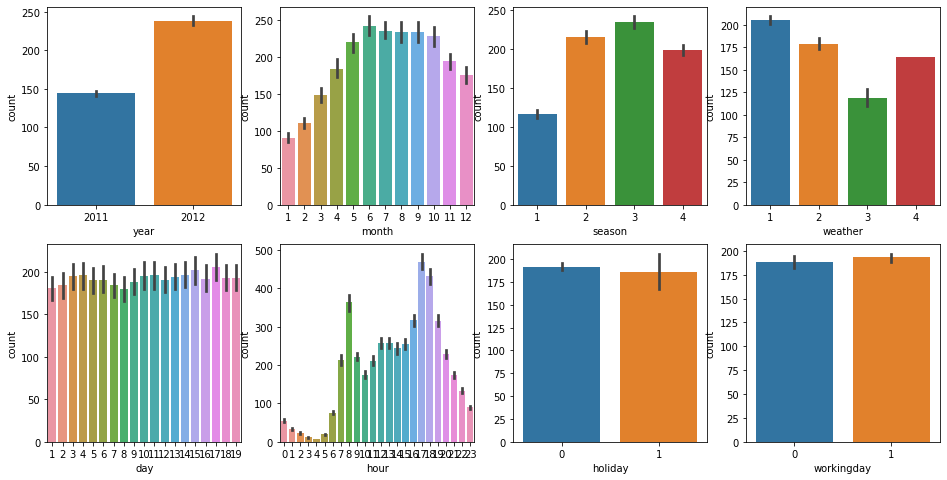

In [32]:
fig, axs = plt.subplots(figsize=(16, 8), ncols=4, nrows=2)

cat_features = ['year', 'month','season','weather','day', 'hour', 'holiday','workingday']

# cat_features에 있는 모든 칼럼별로 개별 칼럼값에 따른 count의 합을 barplot으로 시각화

for i, feature in enumerate(cat_features):
    row = int(i/4)
    col = i%4
    # 시본의 barplot을 이용해 칼럼값에 따른 count의 합을 표현
    sns.barplot(x=feature, y='count', data=bike_df, ax=axs[row][col])

# # 다양한 모델로 예측

## ## MSE, RMSE, RMSLE 계산 함수화

In [33]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# log 값 변환 시 NaN등의 이슈로 log() 가 아닌 log1p() 를 이용하여 RMSLE 계산
def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

# 사이킷런의 mean_square_error() 를 이용하여 RMSE 계산
def rmse(y,pred):
    return np.sqrt(mean_squared_error(y,pred))

# MSE, RMSE, RMSLE 를 모두 계산 
def evaluate_regr(y,pred):
    rmsle_val = rmsle(y,pred)
    rmse_val = rmse(y,pred)
    # MAE 는 scikit learn의 mean_absolute_error() 로 계산
    mae_val = mean_absolute_error(y,pred)
    print('RMSLE: {0:.3f}, RMSE: {1:.3F}, MAE: {2:.3F}'.format(rmsle_val, rmse_val, mae_val))

## ## LinearRegression 예측

In [34]:
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.linear_model import LinearRegression , Ridge , Lasso

y_target = bike_df['count']
X_features = bike_df.drop(['count'],axis=1,inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

evaluate_regr(y_test ,pred)

RMSLE: 1.165, RMSE: 140.900, MAE: 105.924


In [48]:
pred

array([5.7353795 , 5.08865258, 4.99393205, ..., 5.86621689, 5.03923437,
       4.31986653])

In [35]:
def get_top_error_data(y_test, pred, n_tops = 5):
    # DataFrame에 컬럼들로 실제 대여횟수(count)와 예측 값을 서로 비교 할 수 있도록 생성. 
    result_df = pd.DataFrame(y_test.values, columns=['real_count'])
    result_df['predicted_count']= np.round(pred)
    result_df['diff'] = np.abs(result_df['real_count'] - result_df['predicted_count'])
    # 예측값과 실제값이 가장 큰 데이터 순으로 출력. 
    print(result_df.sort_values('diff', ascending=False)[:n_tops])
    
get_top_error_data(y_test,pred, n_tops=5)

      real_count  predicted_count   diff
1618         890            322.0  568.0
3151         798            241.0  557.0
966          884            327.0  557.0
412          745            194.0  551.0
2817         856            310.0  546.0


### ### 예측이 실제와 매우 다르다.
  * y값이 정규 분포 형태가 아닌 건 아닐까?

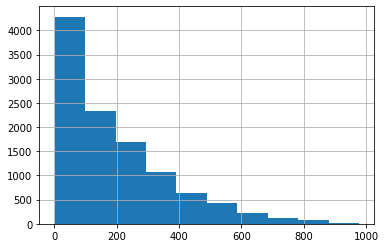

In [36]:
y_target.hist()

### ### y_target 값이 정규 분포 형태가 아니다.
  * 0~200 사이에 왜곡되어 있다.
  * -> 정규 분포 형태로 변환
    - 로그를 적용

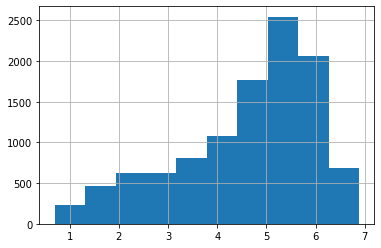

In [37]:
y_log_transform = np.log1p(y_target)
y_log_transform.hist()

## ## 다시 예측 평가

In [38]:
# 타깃 칼럼인 count 값을 log1p로 로그 변환
y_target_log = np.log1p(y_target)

# 로그 변환된 y_target_log를 반영하여 학습/테스트 데이터 셋 분할
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log, test_size=0.3, random_state=0)
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

# 테스트 데이터 셋의 Target 값은 Log 변환되었으므로 다시 expm1를 이용하여 원래 scale로 변환
y_test_exp = np.expm1(y_test)

# 예측 값 역시 Log 변환된 타깃 기반으로 학습되어 예측되었으므로 다시 exmpl으로 scale변환
pred_exp = np.expm1(pred)

evaluate_regr(y_test_exp ,pred_exp)

RMSLE: 1.017, RMSE: 162.594, MAE: 109.286


In [47]:
pred_exp 

array([308.63045453, 161.17120235, 146.5153226 , ..., 351.91134842,
       153.35179351,  74.17859374])

### ### RMSE 값이 오히려 늘었다.
  * 피처들 간의 값이 정규화되지 않았기 때문이 아닐까?

## ## 개별 피처들 인코딩 적용
  * year, hour, month, season, holiday, workingday 피처들의 회귀 계수 영향도가 상대적으로 높게 나온다.
  * year, hour, month 는 숫자로 표현은 되어 있지만
    - 사실 category형 피처이다.
    - 즉, 개별 숫자값의 크기가 의미가 없다. 
    - 알고리즘이 이 숫자값의 크기를 유효하게 볼 가능성이 있다. -> 예측 성능이 떨어진다.
  * 원핫인코딩이 필요하다.

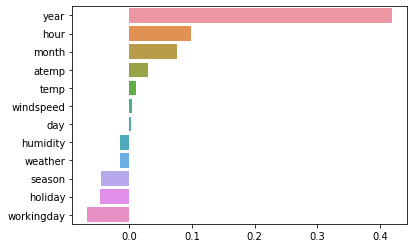

In [39]:
coef = pd.Series(lr_reg.coef_,
                 index = X_features.columns)

coef_sort = coef.sort_values(ascending=False)

sns.barplot(x = coef_sort.values,
            y = coef_sort.index)

plt.savefig('log_transform.tif', 
            format='tif',
            dpi=300, 
            bbox_inches='tight')

### ### [pd.get_dummies()](https://devuna.tistory.com/67)
  * 데이터전처리/가변수 만들기

In [40]:
# 'year', month', 'day', hour'등의 피처들을 One Hot Encoding
X_features_ohe = pd.get_dummies(X_features, columns=['year', 'month','day', 'hour', 'holiday',
                                              'workingday','season','weather'])

In [41]:
X_features_ohe

,temp,atemp,humidity,windspeed,year_2011,year_2012,month_1,month_2,month_3,month_4,...,workingday_0,workingday_1,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4
0,9.84,14.395,81,0.0000,1,0,1,0,0,0,...,1,0,1,0,0,0,1,0,0,0
1,9.02,13.635,80,0.0000,1,0,1,0,0,0,...,1,0,1,0,0,0,1,0,0,0
2,9.02,13.635,80,0.0000,1,0,1,0,0,0,...,1,0,1,0,0,0,1,0,0,0
3,9.84,14.395,75,0.0000,1,0,1,0,0,0,...,1,0,1,0,0,0,1,0,0,0
4,9.84,14.395,75,0.0000,1,0,1,0,0,0,...,1,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,15.58,19.695,50,26.0027,0,1,0,0,0,0,...,0,1,0,0,0,1,1,0,0,0
10882,14.76,17.425,57,15.0013,0,1,0,0,0,0,...,0,1,0,0,0,1,1,0,0,0
10883,13.94,15.910,61,15.0013,0,1,0,0,0,0,...,0,1,0,0,0,1,1,0,0,0
10884,13.94,17.425,61,6.0032,0,1,0,0,0,0,...,0,1,0,0,0,1,1,0,0,0


In [42]:
# 원-핫 인코딩이 적용된 feature 데이터 세트 기반으로 학습/예측 데이터 분할. 
X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, y_target_log,
                                                    test_size=0.3, random_state=0)

# 모델과 학습/테스트 데이터 셋을 입력하면 성능 평가 수치를 반환
def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    if is_expm1 :
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)
    print('###',model.__class__.__name__,'###')
    evaluate_regr(y_test, pred)
# end of function get_model_predict    

# model 별로 평가 수행
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10)
lasso_reg = Lasso(alpha=0.01)

for model in [lr_reg, ridge_reg, lasso_reg]:
    get_model_predict(model,X_train, X_test, y_train, y_test,is_expm1=True)

### LinearRegression ###
RMSLE: 0.590, RMSE: 97.688, MAE: 63.382
### Ridge ###
RMSLE: 0.590, RMSE: 98.529, MAE: 63.893
### Lasso ###
RMSLE: 0.635, RMSE: 113.219, MAE: 72.803


## ## 회귀 계수 높은 피처 다시 시각화

### ### 회귀 계수와 피처 중요도
  * 변수의 중요도를 파악하기 위해 일반 회귀 계수를 비교하지 마세요.
  * 일반 회귀 계수는 각 예측 변수와 반응의 관계를 나타냅니다. 계수 값은 예측 변수가 1단위 증가할 때 반응의 평균이 얼마나 변화하는지 나타냅니다. 결과적으로 계수가 큰 변수가 보다 큰 응답 변화를 나타내므로 더 중요하다고 생각하기 쉽습니다.
  * 하지만 여러 변수 유형에 따라 단위가 다르므로 직접적인 비교는 불가능합니다. 예를 들어, 온도, 무게 또는 화학성분 농도에서 1단위 변화의 의미는 매우 다릅니다.
  * 게다가 이 문제는 각 측정 유형 내에서도 여러 단위가 존재하므로 더욱 복잡해집니다. 예를 들어, 무게는 그램(g)과 킬로그램(kg) 단위로 측정할 수 있습니다. 같은 데이터 세트에 대해 어떤 모형에서는 그램을 사용하고 다른 모형에서는 킬로그램을 사용하여 모형을 적합화하면 모형 의 적합화가 그대로임에도 불구하고 무게 계수가 최대 1,000배까지 변화할 수 있습니다. 즉, 변수의 중요도는 동일한데 계수 값이 크게 변화하게 됩니다.
  * 요점: 계수가 크다고 해서 예측 변수가 더 중요한 것은 아닙니다.

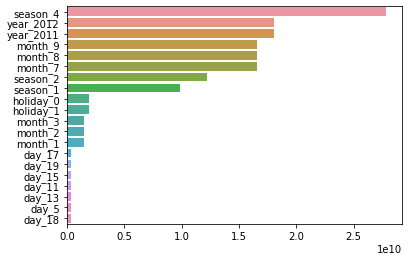

In [43]:
coef = pd.Series(lr_reg.coef_ , 
                 index=X_features_ohe.columns)

coef_sort = coef.sort_values(ascending=False)[:20]

sns.barplot(x=coef_sort.values , y=coef_sort.index)

## ## 회귀 트리로 예측

In [44]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# 랜덤 포레스트, GBM, XGBoost, LightGBM model 별로 평가 수행
rf_reg = RandomForestRegressor(n_estimators=500)
gbm_reg = GradientBoostingRegressor(n_estimators=500)
xgb_reg = XGBRegressor(n_estimators=500)
lgbm_reg = LGBMRegressor(n_estimators=500)

for model in [rf_reg, gbm_reg, xgb_reg, lgbm_reg]:
    # XGBoost의 경우 DataFrame이 입력 될 경우 버전에 따라 오류 발생 가능.
    # -> ndarray로 변환.
    get_model_predict(model,
                      X_train.values,
                      X_test.values, 
                      y_train.values,
                      y_test.values,
                      is_expm1=True)

### RandomForestRegressor ###
RMSLE: 0.353, RMSE: 50.202, MAE: 31.088
### GradientBoostingRegressor ###
RMSLE: 0.330, RMSE: 53.316, MAE: 32.729
[05:15:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
### XGBRegressor ###
RMSLE: 0.345, RMSE: 58.245, MAE: 35.768
### LGBMRegressor ###
RMSLE: 0.319, RMSE: 47.215, MAE: 29.029
